In [9]:
import json

JSON_FILE = 'results.json'

data = json.load(open(JSON_FILE))
data = data['VGG11']

methods = list(data.keys())
print(methods)

for m in methods:
    layers = list(data[m].keys())
    layers.sort(key=lambda x: int(x.split('.')[-1]))
    print(layers)
    break

avg_drop = {method: [data[method][layer]['avg_drop'] for layer in layers] for method in methods}
increase = {method: [data[method][layer]['increase'] for layer in layers] for method in methods}
insertion_curve_AUC = {method: [data[method][layer]['insertion_curve_AUC'] for layer in layers] for method in methods}
deletion_curve_AUC = {method: [data[method][layer]['deletion_curve_AUC'] for layer in layers] for method in methods}

['_DeepLiftShap', '_GradCAMPlusPlus']
['features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20']


In [10]:
import sys
sys.path.append('../')

from models import vgg11_PascalVOC
model = vgg11_PascalVOC()

layer_types = []
for i, layer in enumerate(layers):
    layer_type = model.features[int(layer.split(".")[-1])].__class__.__name__
    if layer_type not in layer_types:
        layer_types.append(layer_type)

layer_types

['Conv2d', 'ReLU', 'MaxPool2d']

In [11]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

For inserion curve AUC and deletion curve AUC, the paper don't provide average values for the whole datasets, but only provides 2 simple examples with very different values (Fig. 3)

In [12]:
# PAPER VALUES

PAPER_AVG_DROP = 13.2
PAPER_INCREASE = 32.7

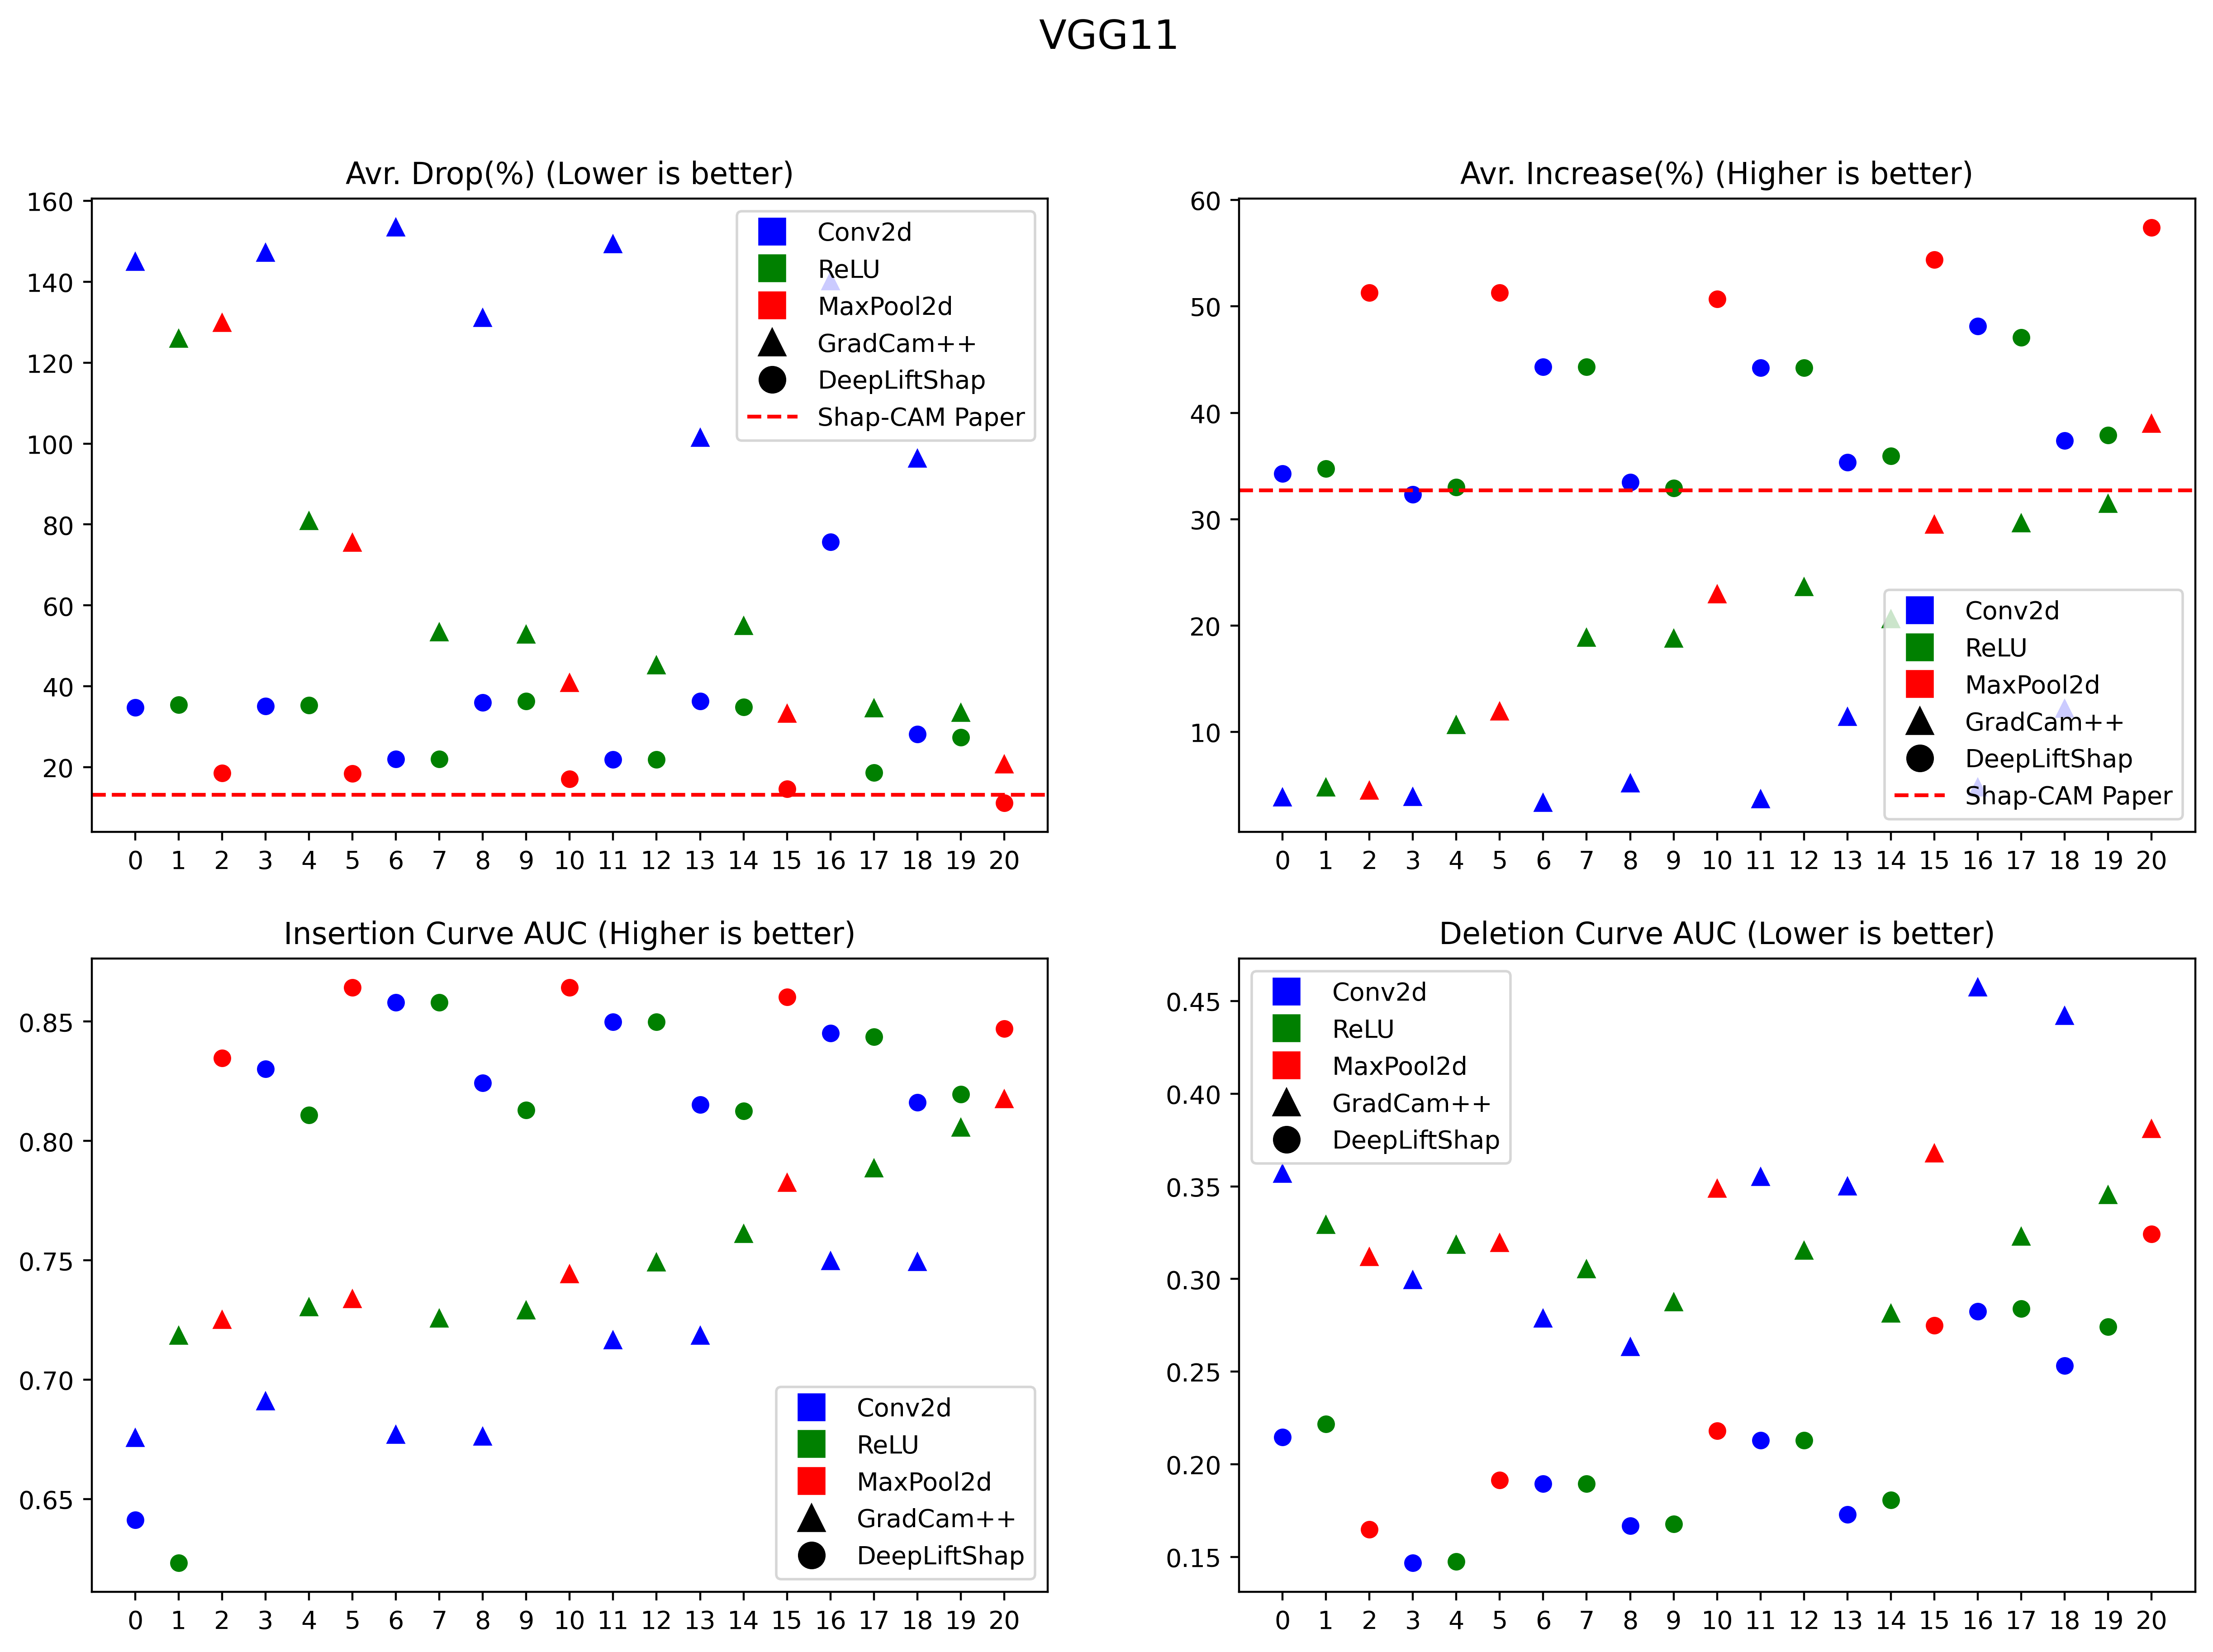

In [30]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

color_for_layers = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
shape_for_methods = {"GradCam++": "^","DeepLiftShap": "o"}  # Define shape mapping
metrics = [avg_drop, increase, insertion_curve_AUC, deletion_curve_AUC]
titles = ['Avr. Drop(%) (Lower is better)', 'Avr. Increase(%) (Higher is better)', 'Insertion Curve AUC (Higher is better)', 'Deletion Curve AUC (Lower is better)']
plt.figure(figsize=(15,10), dpi=400)
plt.tight_layout()
plt.suptitle('VGG11', fontsize=16)

for i, metric in enumerate([avg_drop, increase, insertion_curve_AUC, deletion_curve_AUC]):
    plt.subplot(2,2,i+1)
    for index, layer_type in enumerate(layer_types):
        indices = [i for i, layer in enumerate(layers) if model.features[int(layer.split(".")[-1])].__class__.__name__ == layer_type]
        color = color_for_layers[index]
        for method in methods:
            plt.plot(indices, [metric[method][i] for i in indices], "o" if method == "_DeepLiftShap" else "^", label=layer_type, color=color)

    plt.xticks(range(len(layers)))

    # Create color legend (Layer Types)
    color_legend = [mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=10, label=layer) 
                    for color, layer in zip(color_for_layers, layer_types)]

    # Create shape legend (Methods)
    shape_legend = [mlines.Line2D([], [], color='black', marker=shape, linestyle='None', markersize=10, label=method) 
                    for method, shape in shape_for_methods.items()]
    
    if i == 0:
        plt.axhline(y=PAPER_AVG_DROP, color='r', linestyle='--', label='Shap-CAM Paper')
    if i == 1:
        plt.axhline(y=PAPER_INCREASE, color='r', linestyle='--', label='Shap-CAM Paper')

    if i == 0 or i == 1:
        shape_legend.append(mlines.Line2D([], [], color='r', marker='', linestyle='--', markersize=10, label='Shap-CAM Paper'))

    plt.title(titles[i])
    plt.legend(handles=color_legend + shape_legend)

plt.savefig('results.pdf', dpi=400, bbox_inches='tight')